In [1]:
import sys 
sys.path.insert(0, "../../src")
from normalizevideos import CURRENT_DIR, data_dir

from CorInfoMaxBSS import OnlineCorInfoMax, CorInfoMaxVideoSeparation
from general_utils import display_matrix
from bss_utils import ZeroOneNormalizeColumns
from visualization_utils import Subplot_RGB_images
from dsp_utils import psnr

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.stats import ortho_group
import os
import cv2
import pylab as pl
from tqdm import tqdm
from IPython.display import display, Latex, Math, clear_output
from IPython import display as display1
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import zipfile

FRAMES = 300

In [2]:
ship_img = []
bird_img = []
guitar_img = []

for i in range(FRAMES):
    ship_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "SHIP", f"{i+1}.jpg")))
    bird_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "BIRD", f"{i+1}.jpg")))
    guitar_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "GUITAR", f"{i+1}.jpg")))

ship_img = np.array(ship_img)
bird_img = np.array(bird_img)
guitar_img = np.array(guitar_img)

In [3]:
frame_sizes = [360, 640]
ship_image_shape = ship_img.shape
bird_image_shape = bird_img.shape
guitar_image_shape = guitar_img.shape
# An array to hold the corresponding frames of the videos
# for ex: [bird_img[0], drift_img[0], guitar_img[0]]
same_frame = []
small_images = []
for i in tqdm(range(FRAMES)):
    ship_img_ = cv2.resize(ship_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/ship_image_shape[1],
                           fy=frame_sizes[1]/ship_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    bird_img_ = cv2.resize(bird_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/bird_image_shape[1],
                           fy=frame_sizes[1]/bird_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    guitar_img_ = cv2.resize(guitar_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/guitar_image_shape[1],
                           fy=frame_sizes[1]/guitar_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    same_frame.append([ship_img_, bird_img_, guitar_img_])
    small_images.append([same_frame[i][0].reshape(-1,)/255, same_frame[i][1].reshape(-1,)/255, same_frame[i][2].reshape(-1,)/255])
    
small_images = np.array(small_images)
print(small_images.shape)

100%|██████████| 300/300 [00:03<00:00, 77.48it/s]


(300, 3, 691200)


In [4]:
test_s = small_images[0][[0, 1, 2]]
print("Coefficient Correlation Matrix of the first frames:")
display_matrix(np.corrcoef(test_s))

Coefficient Correlation Matrix of the first frames:


<IPython.core.display.Math object>

In [5]:
# Take three sources and create five mixtures
n_mixtures = 5
n_sources = 3

np.random.seed(250)

A = np.random.standard_normal((n_mixtures, n_sources))
minA = np.min(A)
min_abs = np.abs(minA)

for i in range(n_mixtures):
    for j in range(n_sources):
        if A[i, j] <= 0:
            A[i, j] += min_abs + 0.1
        elif A[i, j] + minA >= 0:
            A[i, j] += minA
        
# A = ortho_group.rvs(3) # Make it an orthogonal matrix instead
# A = np.random.uniform(0.1, 2, (n_mixtures, n_sources))

print(f"Mixture Matrix:")
display_matrix(A)

Mixture Matrix:


<IPython.core.display.Math object>

In [6]:
X_arr = [] # Mixtures for each frame
X_plot_arr = []
S_arr = [] # Keeps the three S matrices

for i in tqdm(range(FRAMES)):
    temp = []

    s = small_images[i][[0, 1, 2]]
    S = s
    S_arr.append(S)

    X = A @ S

    X_plot_arr.append(ZeroOneNormalizeColumns(X.T).T)
    temp.append(X)
    
    X_arr.append(np.array(temp))

X_arr = np.array(X_arr)
X_arr = X_arr.reshape(FRAMES, n_mixtures, 691200)
X_arr += 0.001 * np.random.randn(*X_arr.shape)
S_arr = np.array(S_arr)
X_plot_arr = np.array(X_plot_arr)
S_plot_arr = ZeroOneNormalizeColumns(S_arr)
print(X_arr.shape)
print(S_arr.shape)
print(X_plot_arr.shape)
print(S_plot_arr.shape)

100%|██████████| 300/300 [00:20<00:00, 14.65it/s]


(300, 5, 691200)
(300, 3, 691200)
(300, 5, 691200)
(300, 3, 691200)


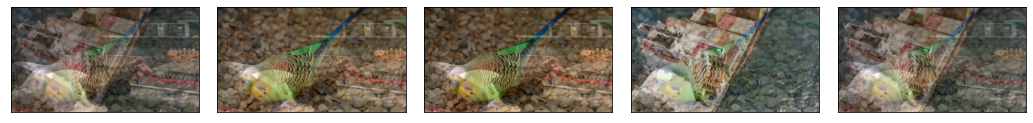

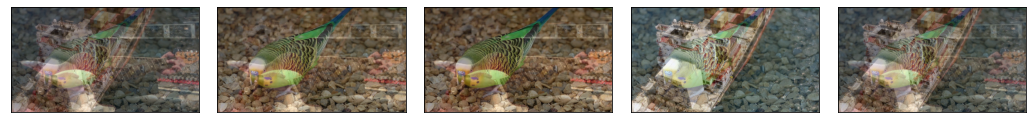

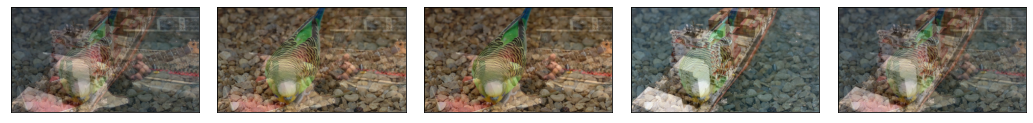

In [7]:
Subplot_RGB_images(X_plot_arr[60], imsize = [360, 640], height=3, width=15) # Second 2
Subplot_RGB_images(X_plot_arr[120], imsize = [360, 640], height=3, width=15) # Second 4
Subplot_RGB_images(X_plot_arr[180], imsize = [360, 640], height=3, width=15) # Second 6

# Saving 3 Mixture Videos

In [8]:
# mix_dir = os.path.join(CURRENT_DIR, "Mix-Videos")
# if not os.path.exists(mix_dir):
#     os.mkdir(mix_dir)
# # mix1 = cv2.VideoWriter(os.path.join(mix_dir, "mix1.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
# # mix2 = cv2.VideoWriter(os.path.join(mix_dir, "mix2.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
# # mix3 = cv2.VideoWriter(os.path.join(mix_dir, "mix3.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))

# mix1 = cv2.VideoWriter(os.path.join(mix_dir, "mix1.mp4"), cv2.VideoWriter_fourcc(*'MP4V'), 30, (640, 360))
# mix2 = cv2.VideoWriter(os.path.join(mix_dir, "mix2.mp4"), cv2.VideoWriter_fourcc(*'MP4V'), 30, (640, 360))
# mix3 = cv2.VideoWriter(os.path.join(mix_dir, "mix3.mp4"), cv2.VideoWriter_fourcc(*'MP4V'), 30, (640, 360))

# for i in tqdm(range(FRAMES)):
#     mix1.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][0].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
#     mix2.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][1].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
#     mix3.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][2].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))

# mix1.release()
# mix2.release()
# mix3.release()

In [9]:
(450*0.3*1e-1/3 )/(0.7 * (1 - 1e-1/3))

6.65024630541872

In [10]:
lambday = 1 - 1e-1/10
lambdae = 0.3
# lambdae = 1 - 1e-1/3
s_dim = S.shape[0]
x_dim = X.shape[0]

n_iter = 3750000
ppf = 60
Wf_arr = []

# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 6.65 * np.eye(s_dim)

debug_iteration_point = n_iter // (FRAMES - 1)
model = CorInfoMaxVideoSeparation(  s_dim = s_dim, x_dim = x_dim, muW = 60*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = S, A = A)

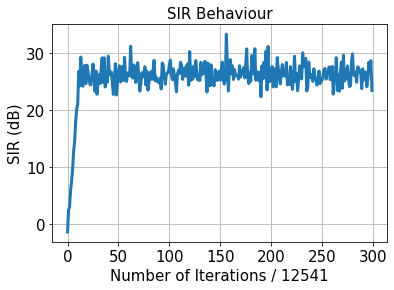

100%|██████████| 3750000/3750000 [06:20<00:00, 9847.86it/s] 


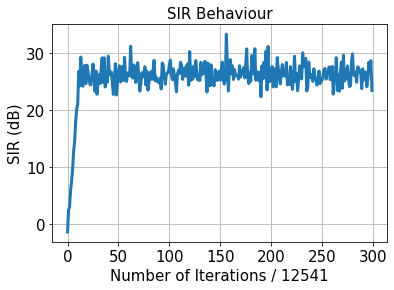

In [11]:
aa = model.seperate_videos(Wf_list = Wf_arr, n_pixel_per_frame=ppf, X = X_arr, 
                           n_iter = n_iter, neural_dynamic_iterations = 500,
                           plot_in_jupyter = True, neural_lr_start = 0.5,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                           shuffle = True)

In [12]:
X = X_arr[0]
S = S_arr[0]
# Wf = model.compute_overall_mapping(return_mapping = True)
Wf_arr = np.array(Wf_arr)
Y = Wf_arr[-1] @ X
Y.shape, X.shape, S.shape, Wf_arr.shape

((3, 691200), (5, 691200), (3, 691200), (300, 3, 5))

In [13]:
Y_reconstructed_frames = [ZeroOneNormalizeColumns(-(Wf_arr[i] @ X_arr[i,:,:]).T).T for i in tqdm(range(FRAMES))]
Y_reconstructed_frames = np.array(Y_reconstructed_frames)
Y_reconstructed_frames.shape

100%|██████████| 300/300 [00:11<00:00, 25.80it/s]


(300, 3, 691200)

In [14]:
psnr_list_intime = []
for i in tqdm(range(FRAMES)):
    psnr0 = psnr(Y_reconstructed_frames[i,0,:], S_arr[i,0,:])
    psnr1 = psnr(Y_reconstructed_frames[i,1,:], S_arr[i,1,:])
    psnr2 = psnr(Y_reconstructed_frames[i,2,:], S_arr[i,2,:])
    psnr_list_intime.append([psnr0, psnr1, psnr2])


100%|██████████| 300/300 [00:02<00:00, 104.24it/s]


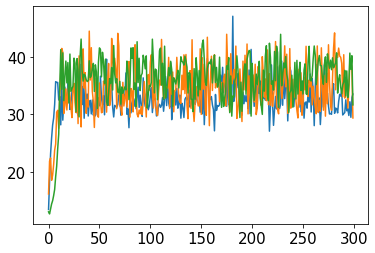

In [15]:
plt.plot(np.array(psnr_list_intime))
plt.show()

In [16]:
psnr_list_intime[-1]

[33.52002531277788, 29.36831479052603, 31.637996182724283]

In [17]:
Y_reconstructed_frames_final = [ZeroOneNormalizeColumns(-(Wf_arr[-1] @ X_arr[i,:,:]).T).T for i in tqdm(range(FRAMES))]
Y_reconstructed_frames_final = np.array(Y_reconstructed_frames_final)
Y_reconstructed_frames_final.shape

100%|██████████| 300/300 [00:07<00:00, 37.81it/s]


(300, 3, 691200)

In [18]:
psnr_list = []
for i in tqdm(range(FRAMES)):
    psnr0 = psnr(Y_reconstructed_frames_final[i,0,:], S_arr[i,0,:])
    psnr1 = psnr(Y_reconstructed_frames_final[i,1,:], S_arr[i,1,:])
    psnr2 = psnr(Y_reconstructed_frames_final[i,2,:], S_arr[i,2,:])
    psnr_list.append([psnr0, psnr1, psnr2])


100%|██████████| 300/300 [00:01<00:00, 192.26it/s]


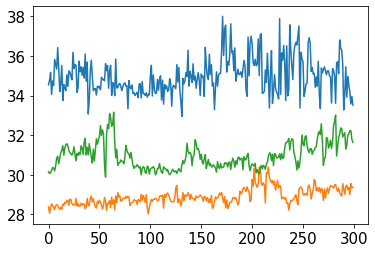

In [19]:
plt.plot(np.array(psnr_list))
plt.show()

In [20]:
np.mean(np.array(psnr_list), 0)

array([34.99011301, 28.89969713, 30.97303054])

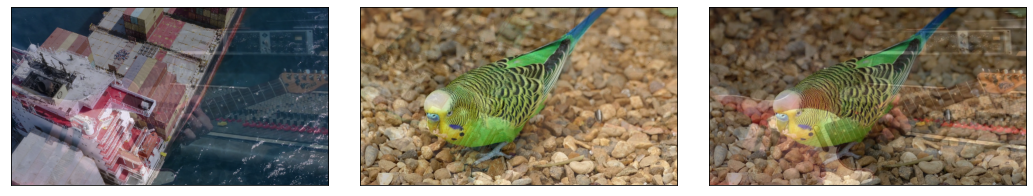

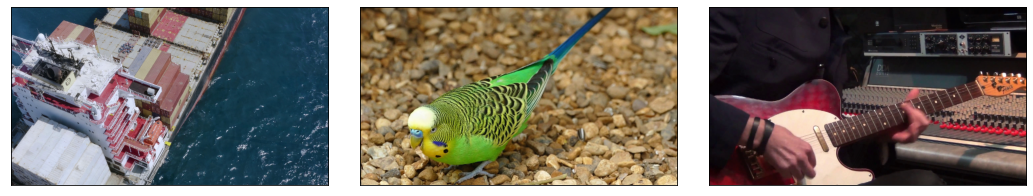

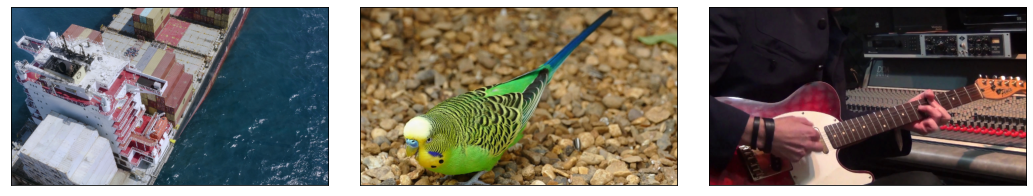

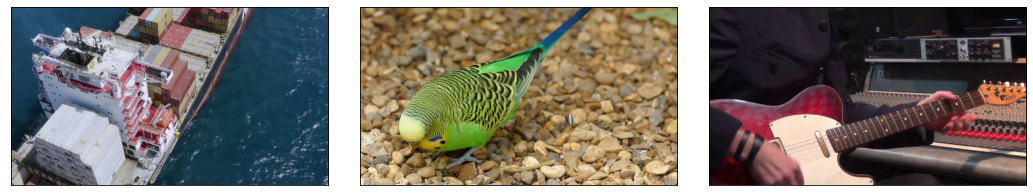

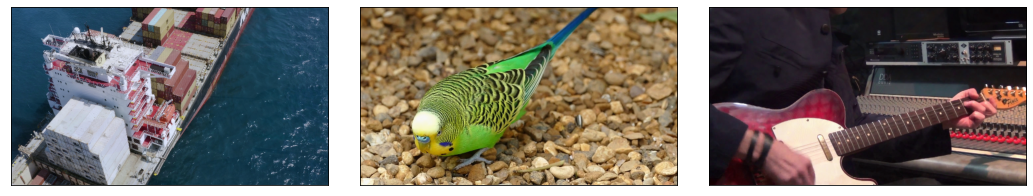

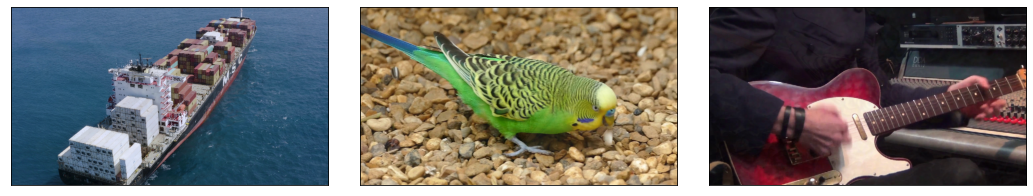

In [21]:
Subplot_RGB_images(Y_reconstructed_frames[1], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[25], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[50], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[80], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[100], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[-1], imsize = [360, 640])

In [22]:
if not os.path.exists("Figures"):
    os.mkdir("Figures")

In [23]:
# Subplot_RGB_images(S_arr[-1], imsize = [360, 640])
# plt.savefig('Figures/Original_Videos_Last_Frames.pdf', format='pdf')
# Subplot_RGB_images(X_plot_arr[-1], imsize = [360, 640])
# plt.savefig('Figures/Mixed_Videos_Last_Frames.pdf', format='pdf')
# Subplot_RGB_images(Y_reconstructed_frames[-1], imsize = [360, 640])
# plt.savefig('Figures/Separated_Videos_Last_Frames.pdf', format='pdf')

# Save Seperated Videos

In [24]:
# sep_dir = os.path.join(CURRENT_DIR, "Separated-Videos")
# if not os.path.exists(sep_dir):
#     os.mkdir(sep_dir)
# # sep1 = cv2.VideoWriter(os.path.join(sep_dir, "sep1.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
# # sep2 = cv2.VideoWriter(os.path.join(sep_dir, "sep2.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
# # sep3 = cv2.VideoWriter(os.path.join(sep_dir, "sep3.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))

# sep1 = cv2.VideoWriter(os.path.join(sep_dir, "sep1.mp4"), cv2.VideoWriter_fourcc(*"MP4V"), 30, (640, 360))
# sep2 = cv2.VideoWriter(os.path.join(sep_dir, "sep2.mp4"), cv2.VideoWriter_fourcc(*"MP4V"), 30, (640, 360))
# sep3 = cv2.VideoWriter(os.path.join(sep_dir, "sep3.mp4"), cv2.VideoWriter_fourcc(*"MP4V"), 30, (640, 360))

# for i in tqdm(range(FRAMES)):
#     sep1.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][0].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
#     sep2.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][1].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
#     sep3.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][2].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    
# sep1.release()
# sep2.release()
# sep3.release()


# Creating the Final Video

In [25]:
DPI = 162

# Modified Subplot_RGB_Images()
def final_vid_subplot(I1, I2, I3, imsize = [360, 640], height = 6, width = 9, title = ''):
    n_images = 3
    images = (I1, I2, I3)
    titles = ("Source Video", "Mixture Video", "Recovered Video")
    
    fig, ax = plt.subplots(3, n_images, figsize = (9, 16)) 
    fig.patch.set_facecolor("black")
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width) 
    for j in range(n_images):
        for i in range(n_images):
            Im = [images[j][i,:].reshape(imsize[0],imsize[1], 3) for i in range(n_images)]
            ax[j][i].set_title(f"{titles[j]} {i+1}", color="white", fontsize=15)
            ax[j][i].imshow(Im[i])
            ax[j][i].axes.xaxis.set_visible(False)
            ax[j][i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.9,\
                    wspace=0.1,\
                    hspace=0.4)
    fig.dpi = DPI 
    return fig

In [26]:
# # final_vid = cv2.VideoWriter(
# #     os.path.join(CURRENT_DIR, "FINAL.avi"), 
# #     cv2.VideoWriter_fourcc(*"MJPG"), 30, (DPI * 9, DPI * 6)) # dpi * 9, dpi * 6
# final_vid = cv2.VideoWriter(
#     os.path.join(CURRENT_DIR, "FINAL2.mp4"), 
#     cv2.VideoWriter_fourcc(*"MP4V"), 30, (648, 432)) # dpi * 9, dpi * 6

# for i in tqdm(range(FRAMES)):
#     fig = final_vid_subplot(S_plot_arr[i], X_plot_arr[i], Y_reconstructed_frames[i])
#     plt.savefig(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))

#     img = Image.open(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))
#     rgb_img = img.convert('RGB')
#     rgb_img.save(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))
    
# #     final_vid.write(cv2.imread(os.path.join(data_dir, f"FINAL-{i+1}.jpg")))
#     final_vid.write(cv2.normalize(cv2.cvtColor(np.array(rgb_img).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
#     os.remove(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))
#     plt.close(fig)
# final_vid.release()